# Human eye iris center detection. 

Tokanov Miras, MS DS m.tokanov@innopolis.university 

In [ ]:
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader , TensorDataset 
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from torchsummary import summary

In [ ]:
# Read dataset, converting to gray
images = []
for img_name in os.listdir(r"gi4e_database\images"):
    if img_name.split('.')[1]=='png':
        img = cv2.cvtColor(cv2.imread(os.path.join(r"gi4e_database\images",img_name)),cv2.COLOR_RGB2GRAY)
        pic=np.asarray(img)
        pic = pic.astype('float32')
        # normalize to the range 0-1
        pic /= 255.0
        images.append(pic)

In [ ]:
# reading all coordinate points from .txt files  
a=""
for i in os.listdir("gi4e_database\labels"):
    with open(os.path.join("gi4e_database\labels",i)) as f:
        lines = f.readlines()
        a=lines

In [ ]:
img_name=[]
#left eye coordinates
left_ext_x1=[]
left_ext_y1=[]
left_centre_x1=[]
left_centre_y1=[]
left_int_x1=[]
left_int_y1=[]

#right eye coordinates
right_ext_x1=[]
right_ext_y1=[]
right_centre_x1=[]
right_centre_y1=[]
right_int_x1=[]
right_int_y1=[]
# splitting lines from .txt by \t and add to list 
for i in a:
    img_name.append(i.split('\t')[0])
    left_ext_x1.append(float(i.split('\t')[1]))
    left_ext_y1.append(float(i.split('\t')[2]))
    left_centre_x1.append(float(i.split('\t')[3]))
    left_centre_y1.append(float(i.split('\t')[4]))
    left_int_x1.append(float(i.split('\t')[5]))
    left_int_y1.append(float(i.split('\t')[6]))
    right_ext_x1.append(float(i.split('\t')[7]))
    right_ext_y1.append(float(i.split('\t')[8]))
    right_centre_x1.append(float(i.split('\t')[9]))
    right_centre_y1.append(float(i.split('\t')[10]))
    right_int_x1.append(float(i.split('\t')[11]))
    right_int_y1.append(float(i.split('\t')[12]))

In [ ]:
# dictionary for dataset
data = {"images":images,"left_ext_x1":left_ext_x1,"left_ext_y1":left_ext_y1,"left_centre_x1":left_centre_x1,"left_centre_y1":left_centre_y1,"left_int_x1":left_int_x1,"left_int_y1":left_int_y1,"right_ext_x1":right_ext_x1,"right_ext_y1":right_ext_y1,"right_centre_x1":right_centre_x1,"right_centre_y1":right_centre_y1,"right_int_x1":right_int_x1,"right_int_y1":right_int_y1}

In [ ]:
df = pd.DataFrame(data)  

In [ ]:
df.head()

,images,left_ext_x1,left_ext_y1,left_centre_x1,left_centre_y1,left_int_x1,left_int_y1,right_ext_x1,right_ext_y1,right_centre_x1,right_centre_y1,right_int_x1,right_int_y1
0,"[[0.99607843, 0.99607843, 0.99607843, 0.996078...",490.63,338.28,471.22,338.41,452.86,341.93,401.95,342.45,383.33,339.84,362.63,338.41
1,"[[0.99607843, 0.99607843, 0.99607843, 0.996078...",493.49,332.94,479.30,333.33,455.86,340.23,404.69,340.11,391.02,334.50,364.58,335.81
2,"[[0.99607843, 0.99607843, 0.99607843, 0.996078...",495.05,333.86,477.47,332.94,458.07,339.32,407.29,339.71,389.45,333.33,368.88,334.89
3,"[[0.99607843, 0.99607843, 0.99607843, 0.996078...",493.62,334.25,472.66,332.42,456.38,338.80,405.08,340.11,385.03,334.11,367.84,336.46
4,"[[0.99607843, 0.99607843, 0.99607843, 0.996078...",495.83,333.33,470.57,331.64,457.68,338.02,406.77,339.45,382.81,333.33,369.92,334.38


# Visualize one image, draw eye corners and iris centers on it

<Figure size 1440x864 with 0 Axes>

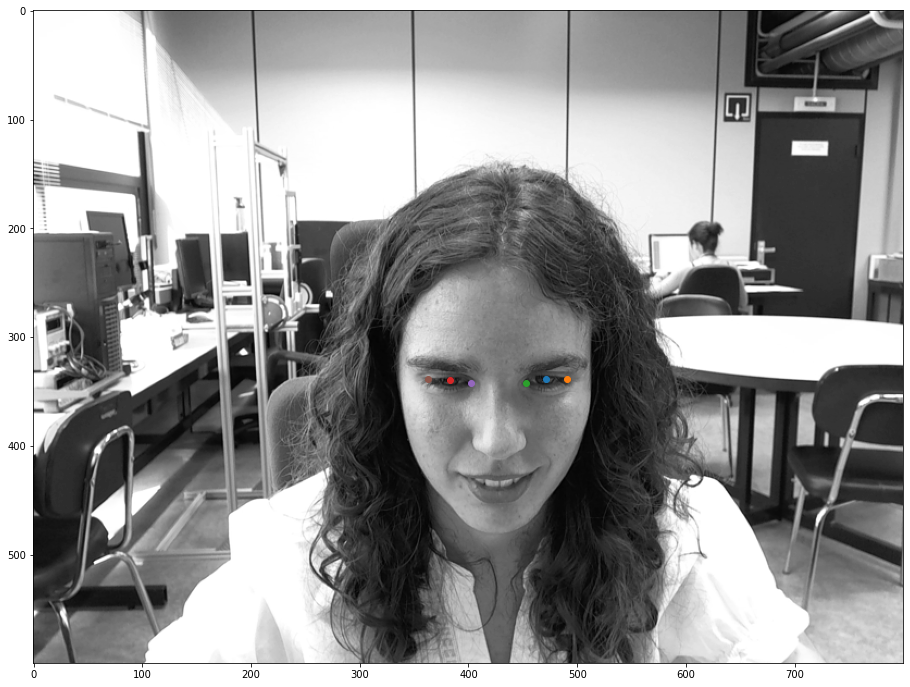

In [ ]:
# plot image and draw coordinates
plt.figure(figsize=(20,12))
fig, axis = plt.subplots(figsize=(20,12))

axis.imshow(df.images[0],cmap='gray')
axis.scatter(float(df.left_centre_x1[0]), float(df.left_centre_y1[0]))
axis.scatter(float(df.left_ext_x1[0]), float(df.left_ext_y1[0]))
axis.scatter(float(df.left_int_x1[0]), float(df.left_int_y1[0]))

axis.scatter(float(df.right_centre_x1[0]), float(df.right_centre_y1[0]))
axis.scatter(float(df.right_ext_x1[0]), float(df.right_ext_y1[0]))
axis.scatter(float(df.right_int_x1[0]), float(df.right_int_y1[0]))


                                    Image with coordinates on corners of eyes and iris center

In [ ]:
# creating dataset
target_data=[]
X_data=[]

for i in range(len(df.images)):
    # new temp image with 0 vales (just black img)
    img = np.zeros([48,48])
    img.fill(0)
    y1=int(df.left_ext_y1[i])
    y2=int(df.left_int_y1[i])
    x1=int(df.left_int_x1[i])
    x2=int(df.left_ext_x1[i])
    x_dif = x2 - x1
    # crop and resize image
    crop_img = df.images[i][y1 - x_dif//2:y1 + x_dif//2 + x_dif%2,x1:x2]
    image_resized = resize(crop_img, (48, 48), anti_aliasing=True)
    X_data.append(image_resized)
    
    img[int((float(df.left_centre_y1[i])-y1 + x_dif//2) * (48/crop_img.shape[0]))][int((float(df.left_centre_x1[i])-float(df.left_int_x1[i])) * (48/crop_img.shape[0]))]=1
    
    # Gaussian blur on target point
    img = ndimage.binary_dilation(img, structure=ndimage.generate_binary_structure(2, 2)).astype(img.dtype)
    img = gaussian_filter(img, sigma=1)
    
    target_data.append(img)
    
# train and target 
df["X_values"] = X_data
df["target"] = target_data

In [ ]:
# add channel to (1,48,48) format
X = torch.Tensor(df.X_values)[:, np.newaxis]
y = torch.Tensor(df.target)[:, np.newaxis]

# Split data

In [ ]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

In [ ]:
from torchsummary import summary

In [ ]:
# parameter lists for our Neural Network (optimizers, loss functions, activation functions) 
optimizers_arr = [torch.optim.RMSprop, torch.optim.Adam, torch.optim.SGD, torch.optim.Adamax]
optim_param = [{"lr": (0.001)}, {"lr": (0.00001)}, {"lr": (0.002),"momentum":(0.5)},{"lr": (0.0002)}]

loss_arr = [torch.nn.MSELoss(), torch.nn.L1Loss()]

activ_func_arr = [torch.nn.Sigmoid(), torch.nn.Tanh(), torch.nn.ReLU()]


In [ ]:
class iris_finder(torch.nn.Module):
                """Neural network which convs images"""
                def __init__(self,activation):
                    """defining convs for my n_network"""
                    super(iris_finder,self).__init__()

                    self.activation = activation

                    self.conv1 = torch.nn.Conv2d(1, 64, 3, 1, 1)
                    self.conv2 = torch.nn.Conv2d(64, 128, 3, 2, 1)
                    self.conv3 = torch.nn.Conv2d(128, 256, 3, 2, 1)
                    self.conv4 = torch.nn.Conv2d(128, 64, 3, 1, 1)
                    self.conv5 = torch.nn.Conv2d(64, 1, 3, 1, 1)

                    #Conv for aux
                    self.conv6 = torch.nn.Conv2d(64, 1, 3, 1, 1)


                    self.deconv1 = torch.nn.ConvTranspose2d(256, 64, 3, 5, 5)
                    #Deconv for aux
                    self.deconv2 = torch.nn.ConvTranspose2d(256, 128, 3, 3, 6)
                    self.deconv3 = torch.nn.ConvTranspose2d(128, 64, 4, 2, 1)
                    self.deconv4 = torch.nn.ConvTranspose2d(64, 1, 3, 1, 1)

                    self.max_pool = torch.nn.MaxPool2d(3)
                    self.leaky = torch.nn.LeakyReLU(0.2)
                    self.sigmoid = torch.nn.Sigmoid()

                def forward(self,x):
                    """description"""

                    #-----------------------------------------

                    x = self.conv1(x)
                    x = self.activation(x)

                    #-----------------------------------------
                    x_skip = x
                    x = self.conv2(x)
                    x = self.activation(x)

                    #-----------------------------------------

                    x = self.conv3(x)
                    x = self.activation(x)
                    #aux x
                    x_aux = x
                    #-----------------------------------------

                    x = self.deconv1(x)
                    x = self.activation(x)

                    #-----------------------------------------

                    x = torch.cat((x, x_skip), 1)

                    #-----------------------------------------

                    x = self.conv4(x)
                    x = self.activation(x)        

                    #-----------------------------------------

                    x = self.conv5(x)
                    x = self.sigmoid(x)


                    #auxiliary NN---------------------------------
                    x_aux = self.deconv2(x_aux)
                    x_aux = self.activation(x_aux)

                    #------------------------------------

                    x_aux = self.deconv3(x_aux)
                    x_aux = self.activation(x_aux)

                    #-------------------------------------

                    x_aux = self.deconv4(x_aux)
                    x_aux = self.sigmoid(x_aux)

                    return x, x_aux

In [ ]:
# train NN on each parameter
for i in loss_arr:
    for j in activ_func_arr:
        for num, k in enumerate(optimizers_arr):
            
            model = iris_finder(j) # j is activation function
            
            #summary(model, (1, 48, 48))
            
            loss = i # loss function 
            optimizer = k(model.parameters(),**optim_param[num]) # params for optimizer 
            
            # to Tensor and create Dataloader
            batch_size = 10
            train_dataset = TensorDataset(X_train, y_train) 
            train_loader = DataLoader(train_dataset, batch_size=batch_size)

            device = 'cuda' if torch.cuda.is_available() else 'cpu'
            model  = model.to(device)

            log_rate = 10 # just to know what happens between my epochs

            for epoch in range(10):
                model.train()
                for batch_ndx, (data,target) in enumerate(train_loader):
                    optimizer.zero_grad()

                    data, target = data.to(device), target.to(device)

                    output_base, output_aux = model(data)
                    loss_values_base = loss(output_base, target)

                    loss_values_aux = loss(output_aux, data)

                    loss_sum = loss_values_base + loss_values_aux 

                    loss_sum.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    for batch_ndx, (data,target) in enumerate(test_loader):

                        data, target = data.to(device), target.to(device)

                        output_base, output_aux = model(data)
                        loss_values_base = loss(output_base, target)

                        loss_values_aux = loss(output_aux, data)

                        loss_sum = loss_values_base + loss_values_aux

            print(f"Metric {i}, Activation function {j}, Optimizer {k}, loss: {loss_sum}")
                
                 

Metric MSELoss(), Activation function Sigmoid(), Optimizer <class 'torch.optim.rmsprop.RMSprop'>, loss: 0.07174232602119446
Metric MSELoss(), Activation function Sigmoid(), Optimizer <class 'torch.optim.adam.Adam'>, loss: 0.050121452659368515
Metric MSELoss(), Activation function Sigmoid(), Optimizer <class 'torch.optim.sgd.SGD'>, loss: 0.05100451037287712
Metric MSELoss(), Activation function Sigmoid(), Optimizer <class 'torch.optim.adamax.Adamax'>, loss: 0.04773971438407898
Metric MSELoss(), Activation function Tanh(), Optimizer <class 'torch.optim.rmsprop.RMSprop'>, loss: 0.2233613133430481
Metric MSELoss(), Activation function Tanh(), Optimizer <class 'torch.optim.adam.Adam'>, loss: 0.012798975221812725
Metric MSELoss(), Activation function Tanh(), Optimizer <class 'torch.optim.sgd.SGD'>, loss: 0.04855905473232269
Metric MSELoss(), Activation function Tanh(), Optimizer <class 'torch.optim.adamax.Adamax'>, loss: 0.010489759966731071
Metric MSELoss(), Activation function ReLU(), Opti

Best: 
Best params for MSELoss() -> Activation function: ReLU(), Optimizer: <class 'torch.optim.rmsprop.RMSprop'>, 
loss: 0.007263504900038242    
Best params for L1Loss() (MAE), Activation function: ReLU(), Optimizer: <class 'torch.optim.rmsprop.RMSprop'>,
loss: 0.05646596848964691

Now we will try to train NN with best parameters... I will use  MSE, ReLU and RMSprop

In [ ]:
activation = torch.nn.ReLU()
model = iris_finder(activation)
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
              ReLU-2           [-1, 64, 48, 48]               0
            Conv2d-3          [-1, 128, 24, 24]          73,856
              ReLU-4          [-1, 128, 24, 24]               0
            Conv2d-5          [-1, 256, 12, 12]         295,168
              ReLU-6          [-1, 256, 12, 12]               0
   ConvTranspose2d-7           [-1, 64, 48, 48]         147,520
              ReLU-8           [-1, 64, 48, 48]               0
            Conv2d-9           [-1, 64, 48, 48]          73,792
             ReLU-10           [-1, 64, 48, 48]               0
           Conv2d-11            [-1, 1, 48, 48]             577
          Sigmoid-12            [-1, 1, 48, 48]               0
  ConvTranspose2d-13          [-1, 128, 24, 24]         295,040
             ReLU-14          [-1, 128,

In [ ]:
batch_size = 10
train_dataset = TensorDataset(X_train, y_train) 
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(X_test, y_test) 
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model  = model.to(device)

In [ ]:
loss = torch.nn.MSELoss() #loss function
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001) # optimizer

In [ ]:
log_rate = 10 

for epoch in range(40):
    model.train()
    for batch_ndx, (data,target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
    
        output_base, output_aux = model(data)
        loss_values_base = loss(output_base, target)
        
        loss_values_aux = loss(output_aux, data)

        loss_sum = loss_values_base + loss_values_aux 
        
        loss_sum.backward()
        optimizer.step()
        
        if not batch_ndx % log_rate:
            print(f"\tLoss: {loss_sum}")
    model.eval()
    with torch.no_grad():
        for batch_ndx, (data,target) in enumerate(test_loader):

            data, target = data.to(device), target.to(device)

            output_base, output_aux = model(data)
            loss_values_base = loss(output_base, target)

            loss_values_aux = loss(output_aux, data)

            loss_sum = loss_values_base + loss_values_aux
    
    print(f"Epoch {epoch+1}, loss: {loss_sum}")

	Loss: 0.31127384305000305
	Loss: 0.023077236488461494
	Loss: 0.01044267974793911
	Loss: 0.013053888455033302
	Loss: 0.010310161858797073
	Loss: 0.012818677350878716
	Loss: 0.00938122533261776
	Loss: 0.010159246623516083
	Loss: 0.008946340531110764
	Loss: 0.008551757782697678
	Loss: 0.012439302168786526
	Loss: 0.010563108138740063
Epoch 1, loss: 0.012667210772633553
	Loss: 0.009157530963420868
	Loss: 0.009225735440850258
	Loss: 0.0073057482950389385
	Loss: 0.0101802172139287
	Loss: 0.008687210269272327
	Loss: 0.008357619866728783
	Loss: 0.008244034834206104
	Loss: 0.00857295747846365
	Loss: 0.007264374755322933
	Loss: 0.0074449507519602776
	Loss: 0.010821755044162273
	Loss: 0.0092024439945817
Epoch 2, loss: 0.010168302804231644
	Loss: 0.0069669196382164955
	Loss: 0.008186779916286469
	Loss: 0.006579874083399773
	Loss: 0.010044306516647339
	Loss: 0.007068263366818428
	Loss: 0.0070789884775877
	Loss: 0.0077489991672337055
	Loss: 0.008643520064651966
	Loss: 0.006765164900571108
	Loss: 0.0

So, after 40 epochs of training, our loss is 0.0056

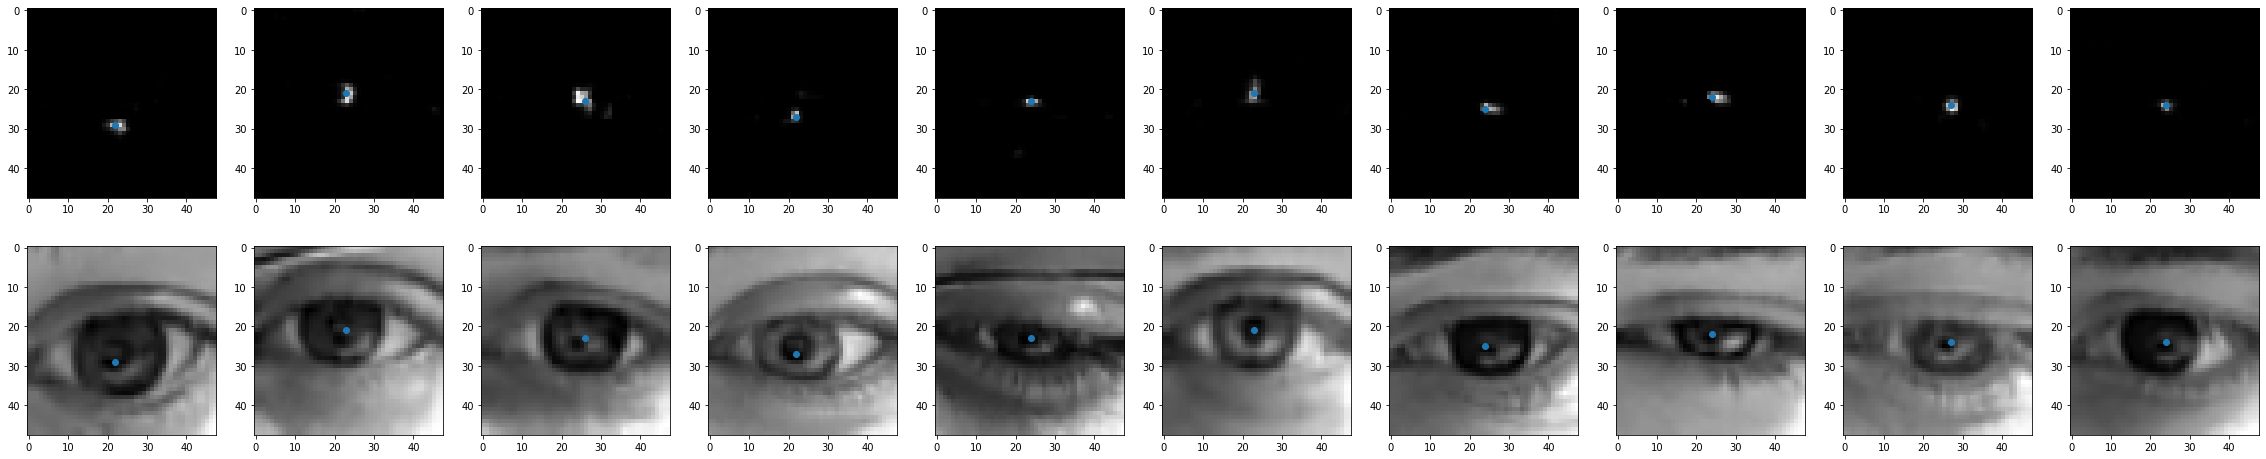

In [ ]:
# plot our results
train_iter = iter(train_loader)
x, y = next(train_iter)
x1, _ = model(x)
x_idx = x1.topk(1, 2)[0].topk(1, 3)[1].squeeze()
y_idx = x1.topk(1, 3)[0].topk(1, 2)[1].squeeze()

figure, axis = plt.subplots(2, 10, figsize=(40, 8)) 

for i in range(10): 
    axis[0][i].imshow(x1[i].squeeze().detach(), cmap="gray")
    axis[0][i].scatter(x_idx[i], y_idx[i]) 
    axis[1][i].imshow(x[i].squeeze().detach(), cmap="gray")
    axis[1][i].scatter(x_idx[i], y_idx[i])

First row is output from our NN and blue point on each image is the brightest pixels(center of iris). Second row is original images with predicted iris center (blur point).

# References

https://stackoverflow.com/a/30230738 

https://stackoverflow.com/a/451580

https://stackoverflow.com/a/69056163

https://stackoverflow.com/a/66907684

https://stackoverflow.com/a/61657036